# Feature Engineering with Convolutional AutoEncoder

이번 실습은 MNIST를 복원하는 AutoEncoder를 만드는 것은 이전 실습과 동일하지만, Encoder와 Decoder에 Conv layer를 활용함으로써 보다 정교한 ConvAutoEncoder를 제작해 보겠습니다.  

(참고)  
https://blog.keras.io/building-autoencoders-in-keras.html  
https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial  
https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95  

In [17]:
import numpy as np

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

from keras.datasets import mnist
import json

import matplotlib.pyplot as plt #for plotting
%matplotlib inline

In [2]:
# to reproduce same training result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

### prepare dataset for ConvAutoEncoder

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape

(60000, 28, 28, 1)

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### AutoEncoder with Deep Conv Layers  

In [5]:
input_shape = x_train.shape[1:]

# this is our input placeholder
input_img = Input(shape=input_shape)

input_shape

(28, 28, 1)

In [6]:
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

decoded = decode_conv_layer_1(encoded)
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
autoencoder=Model(input_img, decoded)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 4)           0         
__________

In [8]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 4)           0         
Total para

In [9]:
decoder_input_shape = tuple(encoded.get_shape().as_list()[1:])

decoder_input_shape

(4, 4, 4)

In [10]:
# input placeholder for decoder
input_decoder = Input(shape=decoder_input_shape)

output_decoder = decode_conv_layer_1(input_decoder)
output_decoder = decode_upsample_layer_1(output_decoder)
output_decoder = decode_conv_layer_2(output_decoder)
output_decoder = decode_upsample_layer_2(output_decoder)
output_decoder = decode_conv_layer_3(output_decoder)
output_decoder = decode_upsample_layer_3(output_decoder)
output_decoder = decode_conv_layer_4(output_decoder)

# this model maps an input to its encoded representation
decoder = Model(input_decoder, output_decoder)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 4, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 4)           148       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 8)           296       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 28, 28, 16)        0         
__________

In [11]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.2499 - val_loss: 0.2054
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1892 - val_loss: 0.1791
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1748 - val_loss: 0.1693
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.1660 - val_loss: 0.1632
Epoch 5/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.1596 - val_loss: 0.1580
Epoch 6/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.1540 - val_loss: 0.1585
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1495 - val_loss: 0.1449
Epoch 8/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1455 - val_loss: 0.1435
Epoch 9/50
60000/60000 [==============================] - 2s 3

### Reconstruction Test

In [12]:
x_test_10 = x_test[:10]
x_test_hat = autoencoder.predict(x_test_10)
z_test = encoder.predict(x_test_10)

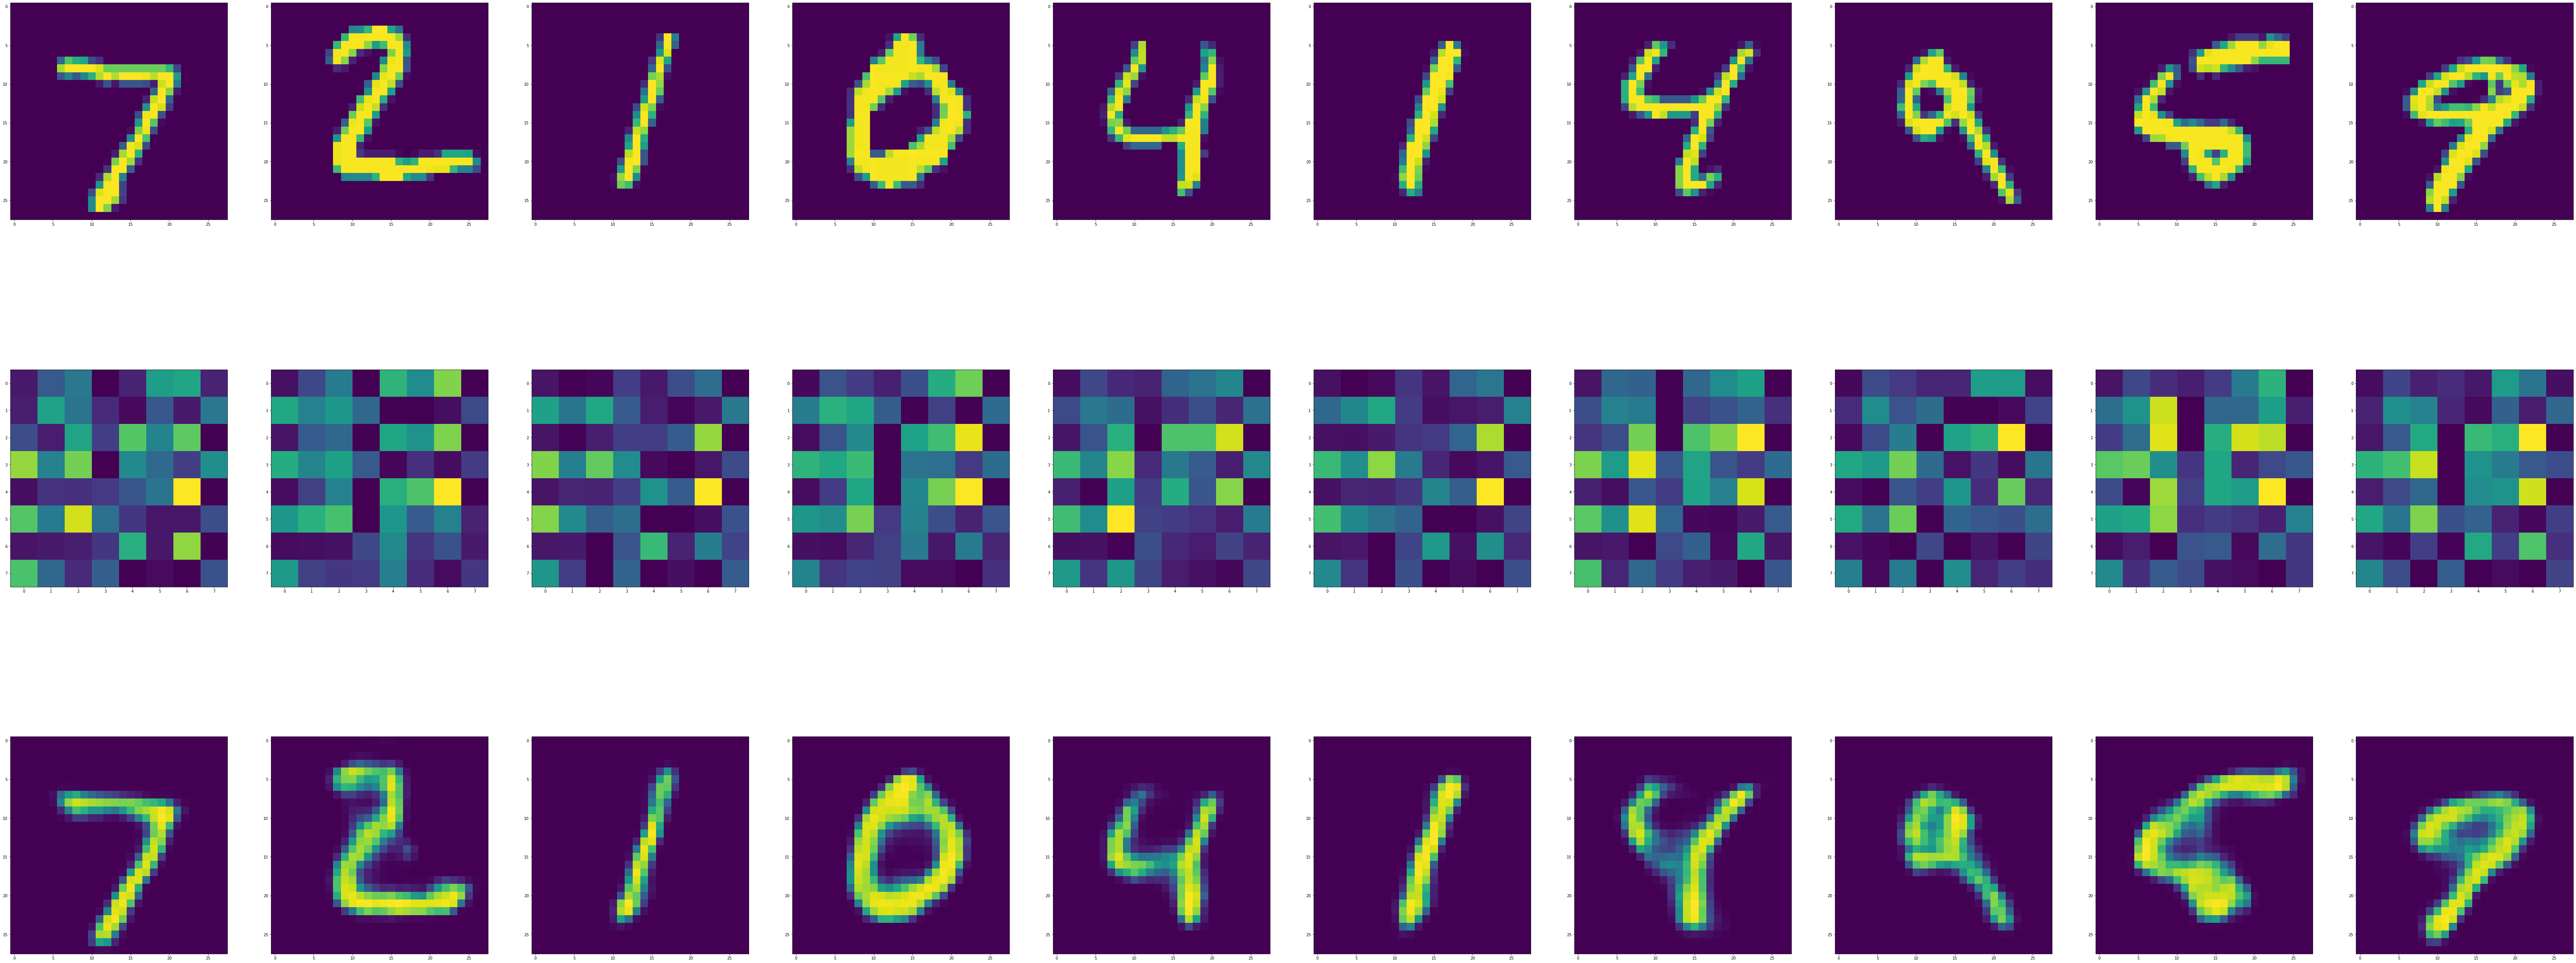

In [16]:
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)
z_test = z_test.reshape(-1, 8, 8)

plt.figure(figsize=(120,50))
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # hidden feature 출력
    plt.subplot(3, 10, i+11)
    plt.imshow(z_test[i])
    # 생성된 이미지 출력
    plt.subplot(3, 10, i+21)
    plt.imshow(x_test_hat_imgs[i])

## save trained encoder model

In [19]:
model_json = encoder.to_json()
with open("checkpoints/conv_ae_encoder.json", "w") as json_file : 
    json.dump(model_json, json_file)

In [20]:
encoder.save_weights("checkpoints/conv_ae_encoder.h5")